<a href="https://colab.research.google.com/github/samaneh-m/Modeling-association-football-scores/blob/main/Dixon_Coles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from math import factorial
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df = pd.read_csv("bundesliga_all_seasons_clean.csv")

df.head()


,Date,HomeTeam,AwayTeam,FTHG,FTAG,B365H,B365D,B365A,Season
0,2020-09-18,Bayern Munich,Schalke 04,8,0,1.10,11.00,21.00,2020_2021
1,2020-09-19,Dortmund,M'gladbach,3,0,1.60,4.33,5.00,2020_2021
2,2020-09-19,Ein Frankfurt,Bielefeld,1,1,1.61,4.20,5.25,2020_2021
3,2020-09-19,FC Koln,Hoffenheim,2,3,2.60,3.50,2.60,2020_2021
4,2020-09-19,Stuttgart,Freiburg,2,3,2.25,3.50,3.10,2020_2021


In [ ]:
LEAGUES = {
    "bundesliga": ("bundesliga_all_seasons_clean.csv", "Bundesliga"),
}


In [ ]:
def load_data():
    df = pd.read_csv("bundesliga_all_seasons_clean.csv")
    df = df.sort_values("Date").reset_index(drop=True)
    print(f"Loaded Bundesliga (all seasons): {len(df)} matches")
    return df


In [ ]:
def split_params(params):
    n = (len(params) - 2) // 2
    alpha = params[:n]
    beta = params[n:2*n]
    gamma = params[2*n]
    rho = params[2*n + 1]
    return alpha, beta, gamma, rho

In [ ]:
def expected_goals(i, j, params):
    alpha, beta, gamma, _ = split_params(params)
    lam = np.exp(alpha[i] - beta[j] + gamma)
    mu = np.exp(alpha[j] - beta[i])
    return lam, mu


In [ ]:
def tau_correction(x, y, lam, mu, rho):
    if x == 0 and y == 0:
        return 1 - lam * mu * rho
    if x == 0 and y == 1:
        return 1 + lam * rho
    if x == 1 and y == 0:
        return 1 + mu * rho
    if x == 1 and y == 1:
        return 1 - rho
    return 1


In [ ]:
def dc_log_likelihood_single(x, y, i, j, params):
    lam, mu = expected_goals(i, j, params)
    _, _, _, rho = split_params(params)

    tau = tau_correction(x, y, lam, mu, rho)
    if tau <= 0:
        return -1e15  # big penalty (or return -np.inf)

    log_px = x * np.log(lam) - lam - np.log(factorial(x))
    log_py = y * np.log(mu)  - mu - np.log(factorial(y))

    return log_px + log_py + np.log(tau)


In [ ]:
def dc_log_likelihood_full(params, data, team_index, xi):
    """
    TOTAL NEGATIVE weighted log-likelihood (Dixon–Coles with time decay).
    """
    n_matches = len(data)

    ll_sum = 0.0
    for k, (_, row) in enumerate(data.iterrows()):
        i = team_index[row["HomeTeam"]]
        j = team_index[row["AwayTeam"]]
        t_diff = n_matches - k - 1
        weight = np.exp(-xi * t_diff)

        ll = dc_log_likelihood_single(
            int(row["FTHG"]),
            int(row["FTAG"]),
            i,
            j,
            params
        )
        ll_sum += weight * ll

    return -ll_sum


In [1]:
def fit_dixon_coles_model(data, team_index, xi):
    """
    Fit Dixon & Coles model WITH time-decay weighting.
    """
    n_teams = len(team_index)
    initial_params = np.zeros(2 * n_teams + 2)
    n_params = 2 * n_teams + 2

    bounds = [(None, None)] * n_params
    bounds[-1] = (-0.5, 0.5)  # rho bound

    result = minimize(
        dc_log_likelihood_full,
        initial_params,
        args=(data, team_index, xi),
        method="L-BFGS-B",
        bounds=bounds
    )
    if not result.success:
        raise RuntimeError(
            f"Optimization failed: {result.message}"
    )

    # -------------------------------
    # Identifiability: sum(alpha) = 0
    # -------------------------------
    params = result.x.copy()
    alpha, beta, gamma, rho = split_params(params)

    m = np.mean(alpha)
    alpha -= m
    beta += m

    params[:n_teams] = alpha
    params[n_teams:2*n_teams] = beta
    result.x = params
    return result


In [ ]:
def match_score_prob_matrix(i, j, params, max_goals=10):
    alpha, beta, gamma, rho = split_params(params)
    lam = np.exp(alpha[i] - beta[j] + gamma)
    mu = np.exp(alpha[j] - beta[i])

    P = np.zeros((max_goals, max_goals))
    for x in range(max_goals):
        for y in range(max_goals):
            px = lam**x * np.exp(-lam) / factorial(x)
            py = mu**y * np.exp(-mu) / factorial(y)
            P[x, y] = px * py * tau_correction(x, y, lam, mu, rho)
    return P

In [ ]:
def predict_match(i, j, params):
    P = match_score_prob_matrix(i, j, params)
    ph = np.sum(P[np.triu_indices_from(P, 1)])
    pd = np.trace(P)
    pa = np.sum(P[np.tril_indices_from(P, -1)])
    s = ph + pd + pa
    return {"H": ph/s, "D": pd/s, "A": pa/s}


In [ ]:
def bookmaker_probabilities(row):
    """
    Convert Bet365 odds to implied probabilities (no margin removal).
    """
    pH = 1.0 / row["B365H"]
    pD = 1.0 / row["B365D"]
    pA = 1.0 / row["B365A"]

    s = pH + pD + pA
    return {"H": pH / s, "D": pD / s, "A": pA / s}



In [ ]:
def realised_return(actual, odds):
    """
    Realised return for a 1-unit bet.
    """
    if actual:
        return odds - 1.0
    else:
        return -1.0

In [ ]:
def table_outcome_probabilities_2025(test_data, team_index, params, n_matches=10):
    """
    Create a Dixon–Coles Table 6 style output:
    match outcome probabilities for selected matches.
    """
    rows = []

    for _, r in test_data.head(n_matches).iterrows():
        probs = predict_match(
            team_index[r["HomeTeam"]],
            team_index[r["AwayTeam"]],
            params
        )

        rows.append({
            "Match": f'{r["HomeTeam"]} vs {r["AwayTeam"]}',
            "Home win": probs["H"],
            "Draw": probs["D"],
            "Away win": probs["A"]
        })

    return pd.DataFrame(rows).round(3)


In [ ]:
def outcome_score_S(xi, data, team_index):
    params = fit_dixon_coles_model(data, team_index, xi).x
    S = 0.0

    for _, row in data.iterrows():
        probs = predict_match(
            team_index[row["HomeTeam"]],
            team_index[row["AwayTeam"]],
            params
        )
        if row["FTHG"] > row["FTAG"]:
            S += np.log(probs["H"] + 1e-12)
        elif row["FTHG"] == row["FTAG"]:
            S += np.log(probs["D"] + 1e-12)
        else:
            S += np.log(probs["A"] + 1e-12)
    return S


In [ ]:
def choose_xi(data, team_index):
    grid = np.linspace(0.0, 0.01, 21)
    scores = []
    for xi in grid:
        print(f"Evaluating xi = {xi:.5f}")
        scores.append(outcome_score_S(xi, data, team_index))

    return grid[np.argmax(scores)]

In [ ]:
def fit_league(data, label, xi):
    teams = sorted(data["HomeTeam"].unique())
    team_index = {t: i for i, t in enumerate(teams)}

    #xi = choose_xi(data, team_index)
    xi = 0.0100
    print(f"{label}: chosen ξ = {xi:.5f}")

    res = fit_dixon_coles_model(data, team_index, xi)
    alpha, beta, gamma, rho = split_params(res.x)

    return {
        "league": label,
        "n_matches": len(data),
        "gamma": gamma,
        "gamma_exp": np.exp(gamma),
        "rho": rho,
        "xi": xi
    }, res.x, team_index



In [ ]:
def actual_label(x, y):
    return "H" if x > y else "D" if x == y else "A"

In [ ]:
def evaluate_model_on_test(data, team_index, params):
    brier = 0.0
    logloss = 0.0

    for _, r in data.iterrows():
        probs = predict_match(
            team_index[r["HomeTeam"]],
            team_index[r["AwayTeam"]],
            params
        )

        act = actual_label(int(r["FTHG"]), int(r["FTAG"]))

        for k in probs:
            brier += (probs[k] - (1 if act == k else 0)) ** 2

        logloss += -np.log(probs[act] + 1e-12)

    n = len(data)
    return brier / n, logloss / n

In [ ]:
def evaluate_league(data, label):
    teams = sorted(data["HomeTeam"].unique())
    team_index = {t: i for i, t in enumerate(teams)}

    VALIDATION_SEASONS = [
    "2022_2023",
    "2023_2024",
    "2024_2025",
    "2025_2026",
    ]

    train = data[~data["Season"].isin(VALIDATION_SEASONS)]
    test  = data[data["Season"].isin(VALIDATION_SEASONS)]

    print(f"Training matches: {len(train)}")
    print(f"Validation matches (4 seasons): {len(test)}")


    # --------------------------------------------------
    # CHOOSE ξ ON TRAINING DATA (paper-consistent)
    # --------------------------------------------------
    xi = choose_xi(train, team_index)

    # --------------------------------------------------
    # FIT MODEL USING TRAINING DATA + ξ
    # --------------------------------------------------
    params = fit_dixon_coles_model(train, team_index, xi).x

    acc = 0
    brier = 0.0
    logloss = 0.0

    for _, r in test.iterrows():
        probs = predict_match(
            team_index[r["HomeTeam"]],
            team_index[r["AwayTeam"]],
            params
        )

        act = actual_label(int(r["FTHG"]), int(r["FTAG"]))
        pred = max(probs, key=probs.get)
        acc += int(pred == act)

        for k in probs:
            brier += (probs[k] - (1 if act == k else 0))**2

        logloss += -np.log(probs[act] + 1e-12)

    n = len(test)
    return {
        "league": label,
        "n_test": n,
        "accuracy": acc / n,
        "brier": brier / n,
        "logloss": logloss / n
    }


In [ ]:
def fit_poisson_model(data, team_index, xi):
    res = fit_dixon_coles_model(data, team_index, xi)
    params = res.x.copy()
    params[-1] = 0.0  # force rho = 0
    return params


In [ ]:
def evaluate_bundesliga(data):
    teams = sorted(data["HomeTeam"].unique())
    team_index = {t: i for i, t in enumerate(teams)}

    train = data[data["Season"] != "2025_2026"]
    test  = data[data["Season"] == "2025_2026"]

    xi = choose_xi(train, team_index)
    params = fit_dixon_coles_model(train, team_index, xi).x

    brier, logloss = evaluate_model_on_test(test, team_index, params)

    return {
        "league": "Bundesliga",
        "n_train": len(train),
        "n_test": len(test),
        "xi": xi,
        "brier": brier,
        "logloss": logloss
    }

In [ ]:
def poisson_vs_dixon_coles_table(data, league_name, xi=0.0100):
    teams = sorted(data["HomeTeam"].unique())
    team_index = {t: i for i, t in enumerate(teams)}

    split = int(0.8 * len(data))
    train = data.iloc[:split]
    test  = data.iloc[split:]

    #xi = choose_xi(train, team_index)

    dc_params = fit_dixon_coles_model(train, team_index, xi).x
    b_dc, l_dc = evaluate_model_on_test(test, team_index, dc_params)

    pois_params = fit_poisson_model(train, team_index, xi)
    b_p, l_p = evaluate_model_on_test(test, team_index, pois_params)

    table = pd.DataFrame({
        "Model": ["Poisson (ρ = 0)", "Dixon–Coles"],
        "Brier score": [b_p, b_dc],
        "Log loss": [l_p, l_dc]
    })

    return table.round(4)

In [ ]:
def bookmaker_probs_and_margin(row):
    inv = np.array([
        1 / row["B365H"],
        1 / row["B365D"],
        1 / row["B365A"]
    ])
    margin = inv.sum() - 1
    probs = inv / inv.sum()
    return probs, margin


In [ ]:
def average_bookmaker_margin(df):
    margins = []

    for _, row in df.iterrows():
        _, margin = bookmaker_probs_and_margin(row)
        margins.append(margin)

    return np.mean(margins)

In [ ]:
def diagnostic_binned_returns(df, n_bins=8):
    """
    Dixon–Coles diagnostic:
    Quantile (equal-count) bins of probability ratio.
    """
    df = df.copy()

    # drop extreme outliers for stability (paper-style trimming)
    df = df[df["ratio"] < df["ratio"].quantile(0.99)]

    # equal-count bins
    df["bin"] = pd.qcut(df["ratio"], q=n_bins, duplicates="drop")

    grouped = (
        df.groupby("bin", observed=True)
        .agg(
            mean_ratio=("ratio", "mean"),
            mean_return=("return", "mean"),
            count=("return", "size"),
        )
        .reset_index()
    )

    return grouped


In [ ]:
def diagnostic_return_data(test_data, team_index, params):
    """
    Dixon–Coles diagnostic data: HOME WINS ONLY (paper-faithful)
    """
    records = []

    for _, r in test_data.iterrows():
        probs = predict_match(
            team_index[r["HomeTeam"]],
            team_index[r["AwayTeam"]],
            params
        )

        # model vs bookmaker probability for HOME WIN
        p_model = probs["H"]
        p_book = 1.0 / r["B365H"]

        ratio = p_model / p_book

        actual = actual_label(int(r["FTHG"]), int(r["FTAG"]))
        ret = realised_return(actual == "H", r["B365H"])

        # Dixon & Coles diagnostic: only consider underpriced home wins
        if ratio > 1:
            records.append({
                "ratio": ratio,
                "return": ret
            })

    return pd.DataFrame(records)


In [ ]:
def plot_diagnostic_return_curve(binned_df, test_df):
    plt.figure(figsize=(8, 5))

    x = binned_df["mean_ratio"]
    y = binned_df["mean_return"]

    plt.plot(x, y, marker="o")
    # bookmaker profit margin reference line
    baseline = -avg_margin  # expected return of bookmaker-implied probabilities

    plt.axhline(
        baseline,
        color="black",
        linestyle="--",
        linewidth=1,
        label=f"Bookmaker expected return = {baseline:.3f}"
    )

    plt.xlabel("Ratio: model probability / bookmaker probability")
    plt.ylabel("Observed mean return")
    plt.title("Diagnostic plot (Dixon–Coles style)")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def attack_defence_table(params, team_index, n_teams=20):
    alpha, beta, _, _ = split_params(params)

    # Invert team_index to get index -> team name
    index_team = {i: t for t, i in team_index.items()}

    rows = []
    for i in range(len(alpha)):
        rows.append({
            "Team": index_team[i],
            "Attack (alpha)": alpha[i],
            "Defence (beta)": beta[i]
        })

    df = pd.DataFrame(rows)

    # Sort by attack strength (descending)
    df = df.sort_values("Attack (alpha)", ascending=False)

    # Keep top n teams (e.g. 20)
    df = df.head(n_teams)

    return df.round(3)


Training matches: 1530
Test matches (2025/26): 126
Chosen xi: 0.01000

Table: Attack and defence parameters (Bundesliga)
          Team  Attack (alpha)  Defence (beta)
 Bayern Munich           0.715           0.429
      Dortmund           0.581           0.188
     Stuttgart           0.407           0.017
    Leverkusen           0.404           0.164
 Ein Frankfurt           0.346           0.186
    M'gladbach           0.186          -0.155
         Mainz           0.179           0.174
 Werder Bremen           0.178           0.123
    Hoffenheim           0.144          -0.262
    RB Leipzig           0.135           0.061
 Holstein Kiel           0.120          -0.297
      Freiburg           0.093           0.033
    Schalke 04          -0.051          -0.319
        Hertha          -0.075          -0.323
  Union Berlin          -0.085          -0.048
     Wolfsburg          -0.120           0.048
       Hamburg          -0.163           0.163
Greuther Furth          -0.175   

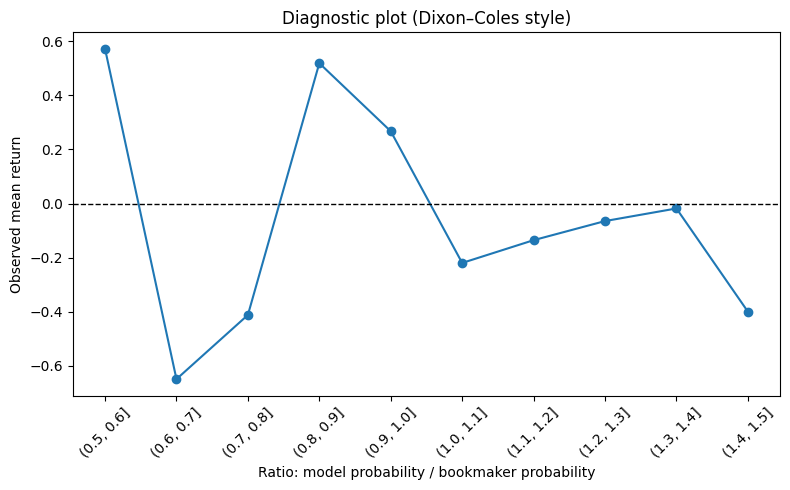


Evaluation on 2025/2026 season:
Brier score: 0.8218
Log loss:    1.3607
Evaluating xi = 0.00000
Evaluating xi = 0.00050
Evaluating xi = 0.00100


KeyboardInterrupt: 

In [ ]:
if __name__ == "__main__":

    # --------------------------------------------------
    # 1. Load Bundesliga multi-season data
    # --------------------------------------------------
    df = pd.read_csv("bundesliga_all_seasons_clean.csv")
    df = df.sort_values("Date").reset_index(drop=True)

    # --------------------------------------------------
    # 2. Team index
    # --------------------------------------------------
    teams = sorted(df["HomeTeam"].unique())
    team_index = {t: i for i, t in enumerate(teams)}

    # --------------------------------------------------
    # 3. Temporal split (paper-faithful)
    # --------------------------------------------------
    train = df[df["Season"] != "2025_2026"]
    test  = df[df["Season"] == "2025_2026"]

    VALIDATION_SEASONS = [
        "2022_2023",
        "2023_2024",
        "2024_2025",
        "2025_2026",
    ]

    train = df[~df["Season"].isin(VALIDATION_SEASONS)]
    test  = df[df["Season"].isin(VALIDATION_SEASONS)]

    print(f"Training matches: {len(train)}")
    print(f"Test matches (2022/26): {len(test)}")

    # --------------------------------------------------
    # 4. Choose xi (Eq. 4.7) on training data
    # --------------------------------------------------
    #xi = choose_xi(train, team_index)
    xi = 0.0100
    print(f"Chosen xi: {xi:.5f}")

    # --------------------------------------------------
    # 5. Fit Dixon–Coles model
    # --------------------------------------------------
    params = fit_dixon_coles_model(train, team_index, xi).x

    # --------------------------------------------------
    # Table: Attack and defence parameters (top teams)
    # --------------------------------------------------
    ad_table = attack_defence_table(
        params=params,
        team_index=team_index,
        n_teams=20
    )

    print("\nTable: Attack and defence parameters (Bundesliga)")
    print(ad_table.to_string(index=False))

    # --------------------------------------------------
    # 6. Evaluate on future season
    # --------------------------------------------------
    brier, logloss = evaluate_model_on_test(test, team_index, params)

    # --------------------------------------------------
    # Diagnostic plot
    # --------------------------------------------------
    diag_df = diagnostic_return_data(test, team_index, params)
    #just for debugging
    print(diag_df["ratio"].describe())
    #end of debugging

    binned = diagnostic_binned_returns(diag_df)
    avg_margin = average_bookmaker_margin(test)
    print("\n[DEBUG] Ratio distribution:")
    print(diag_df["ratio"].describe())
    print("Share of ratio > 1:", (diag_df["ratio"] > 1).mean())


    plot_diagnostic_return_curve(binned, test)
    print("Average bookmaker margin:", avg_margin)
    print("Mean observed return (all bets):", diag_df["return"].mean())


    print("\nEvaluation on validation seasons:")
    print(f"Brier score: {brier:.4f}")
    print(f"Log loss:    {logloss:.4f}")

    # --------------------------------------------------
    # 7. Poisson vs Dixon–Coles (optional but good)
    # --------------------------------------------------
    table = poisson_vs_dixon_coles_table(df, "Bundesliga")
    print("\nPoisson vs Dixon–Coles comparison:")
    print(table.to_string(index=False))

    table6 = table_outcome_probabilities_2025(
        test_data=test,
        team_index=team_index,
        params=params,
        n_matches=10
    )

    print("\nTable: Outcome probabilities (2025/26 season)")
    print(table6.to_string(index=False))



In [ ]:
def create_parameter_table_single(league_label, params, xi):
    alpha, beta, gamma, rho = split_params(params)
    return pd.DataFrame([{
        "League": league_label,
        "exp(gamma)": np.exp(gamma),
        "rho": rho,
        "xi": xi
    }]).round(4)

param_table = create_parameter_table_single("Bundesliga", params, xi)
print("\nParameter estimates:")
print(param_table.to_string(index=False))


